In [2]:
%pip install -q numpy opencv-python-headless==4.2.0.32 \
    torch torchvision==0.5.0 xarray-einstats==0.1 \
    albumentations==0.4.5 tqdm==4.43.0

     |████████████████████████████████| 17.1 MB 7.9 MB/s 
     |████████████████████████████████| 16.9 MB 177 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.14.0 requires torch==1.13.0, but you have torch 1.4.0 which is incompatible.
fastai 2.7.10 requires torch<1.14,>=1.7, but you have torch 1.4.0 which is incompatible.
fastai 2.7.10 requires torchvision>=0.8.2, but you have torchvision 0.5.0 which is incompatible.
arviz 0.12.1 requires xarray-einstats>=0.2, but you have xarray-einstats 0.1 which is incompatible.


In [3]:
import cv2
import json
import itertools
import numpy as np
import os
import shutil
import urllib.request
import pandas as pd

from collections import defaultdict
from pathlib import Path
from tqdm.notebook import tqdm
from zipfile import ZipFile

from matplotlib import pyplot as plt
from PIL import Image

import albumentations as albu
import albumentations.augmentations.functional as AF

import torch
import torch.onnx as onnx
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.models.mobilenet import ConvBNReLU
from torchvision.ops import box_iou, nms

# Set random seeds for the libraries to obtain reproducible results
RANDOM_SEED = 1337
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Flip values for slower training speed, but more determenistic results.
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

In [4]:
DEVICE = torch.device('cpu')
if torch.cuda.is_available():
    DEVICE = torch.device('cuda:0')
    torch.cuda.manual_seed(RANDOM_SEED)
DEVICE

device(type='cpu')

In [5]:
OBJECT_LABELS_UNION = ['tv']


In [6]:
DATASET_PATH = Path('.')  # Path to the dataset
DIR_TO_SAVE_RESULTS = Path('centernet_model')  # Model snapshots will be saved here
os.makedirs(DIR_TO_SAVE_RESULTS, exist_ok=True)

In [7]:
# This number can be different
# The bigger number of epochs, longer training time, but better model quality
# NUM_EPOCHS = 40 # => faster training 
# NUM_EPOCHS = 70

NUM_EPOCHS = 40 # => better quality 

In [8]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NUM_WORKERS = 4  # Number of workers used in PyTorch dataloader

INPUT_SIZE = (128, 256) # width & height
FEATURE_MAP_SIZE_RATIO = 8 # Ratio between output&input size (e.g. 128 / 16 = 8)

# Larger model might yield better results but will be slower.
# width_mult is a coefficient which defines how many filters
# to use from original mobilenet:
MOBILENET_WIDTH_MULTIPLIER = 0.3

# Download data set

In [9]:
def download_and_unpack_file(link, filename, unpack=True):
    """ Download and unpack dataset's annotation files """
    if (DATASET_PATH / filename).exists():
        print("{} already exists".format(filename))
        return
    archname = link.split('/')[-1]
    progress_bar = tqdm(desc=filename,
                        dynamic_ncols=True, leave=False,
                        mininterval=5, maxinterval=30,
                        unit='KiB', unit_scale=True,
                        unit_divisor=1024)
    def update_progress(count, block_size, total_size):
        if progress_bar.total is None:
            progress_bar.reset(total_size)
        progress_bar.update(count * block_size - progress_bar.n)
    urllib.request.urlretrieve(link, archname, reporthook=update_progress)
    urllib.request.urlcleanup()
    progress_bar.close()
    if unpack:
        print("Unpacking the archive...")
        shutil.unpack_archive(archname, DATASET_PATH)
        os.remove(archname)
        print("Successfuly downloaded and extracted archive")

In [10]:
os.listdir("./")


['.config', 'centernet_model', 'sample_data']

In [11]:
# Train set is too big for colab so we will extract only files used in training. You can unpack whole dataset locally if you have enough free space
download_and_unpack_file('http://images.cocodataset.org/zips/train2017.zip', 'train2017', unpack=False)

In [13]:
download_and_unpack_file('http://images.cocodataset.org/annotations/annotations_trainval2017.zip', 'annotations')

annotations already exists


In [14]:
download_and_unpack_file('http://images.cocodataset.org/zips/val2017.zip', 'val2017')

Unpacking the archive...
Successfuly downloaded and extracted archive


# Data class

In [15]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, phase, box_coder=None, transform=None):
        super().__init__()
        self.phase = phase
        self.class_names = OBJECT_LABELS_UNION

        self.dataset = torchvision.datasets.CocoDetection(
            DATASET_PATH / (phase + '2017'),
            annFile=DATASET_PATH / ('annotations/instances_'+phase+'2017.json'))
        self.transform = transform
        self.box_coder = box_coder

        categories = self.dataset.coco.getCatIds()
        categories = self.dataset.coco.loadCats(categories)
        self.all_possible_classes = [category['name'] for category in categories]
        self.negative_classes = set(self.all_possible_classes) - set(self.class_names)

        self.filter_dataset()

        if self.phase == "train":
            self.extract_images()

    def filter_dataset(self):
        """ Leave only classes specified in the OBJECT_LABELS_UNION """
        filter_categories = self.dataset.coco.getCatIds(catNms=self.class_names)
        
        min_area = 500.
        ann_ids = self.dataset.coco.getAnnIds(
            catIds=filter_categories, areaRng=[min_area, float('inf')],
            iscrowd=False)
        im_ids = {self.dataset.coco.anns[ann_idx]['image_id'] for ann_idx in ann_ids}

        if self.phase == "train":  # Use some part of remaining data to reduce the number of false positives
            num_false_positives = len(im_ids) // 20 # 5 percent 
            cat_ids = self.dataset.coco.getCatIds(self.negative_classes)
            for cls_id, neg_class in zip(cat_ids, self.negative_classes):
                neg_subset = set(self.dataset.coco.getAnnIds(catIds=[cls_id], areaRng=[min_area, float('inf')], iscrowd=False))
                neg_im_ids = {self.dataset.coco.anns[ann_idx]['image_id'] for ann_idx in neg_subset}
                neg_im_count = num_false_positives // len(self.negative_classes)
                if neg_class == 'person':
                    neg_im_count *= 10
                neg_im_count = min(neg_im_count, len(neg_im_ids - im_ids))
                neg_subset = list(neg_im_ids - im_ids)[:neg_im_count]
                im_ids.update(neg_subset)

        im_ids = list(im_ids)
        cat_ids = self.dataset.coco.getCatIds(catIds=filter_categories)

        self.dataset.ids = sorted(im_ids)
        self.dataset.coco.anns = {i: self.dataset.coco.anns[i] for i in ann_ids}
        self.dataset.coco.imgs = {i: self.dataset.coco.imgs[i] for i in im_ids}
        self.dataset.coco.cats = {i: self.dataset.coco.cats[i] for i in cat_ids}
        imgToAnns, catToImgs = defaultdict(list), defaultdict(list)

        for k, ann in self.dataset.coco.anns.items():
            imgToAnns[ann['image_id']].append(ann)
            catToImgs[ann['category_id']].append(ann['image_id'])
        self.dataset.coco.imgToAnns = imgToAnns
        self.dataset.coco.catToImgs = catToImgs

    def extract_images(self):
        """ Extract images which will be used """
        im_paths = []
        for im_id in self.dataset.ids:
            im_paths.append(self.dataset.coco.loadImgs(im_id)[0]['file_name'])

        if not os.path.isdir('./train2017'):
            os.mkdir('./train2017')

        with ZipFile('./train2017.zip', 'r') as archive:
            for image in tqdm(im_paths, dynamic_ncols=True, leave=False):
                archive.extract('train2017/' + image, './')
        return

    def parse_annotation(self, annotation):
        bboxes = []
        for anno in annotation:
            # Filter boxes with 0 area
            if (anno['bbox'][2] < 1) or (anno['bbox'][3] < 1) or (anno['iscrowd'] and self.phase != 'val'):
                continue
            # Boxes in form x_left, y_top, w, h
            bboxes.append(anno['bbox'])
        
        return {'bboxes': bboxes, 'labels': [1] * len(bboxes)}

    def __getitem__(self, index):
        image, annotation = self.dataset[index]
    
        annotations = self.parse_annotation(annotation)
        annotations['image'] = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        if self.transform:
            annotations = self.transform(annotations)
       
        if self.box_coder is None:
            return annotations

        annotations['bboxes'] = torch.tensor(annotations['bboxes'])
        encoded_bboxes, encoded_labels = self.box_coder.encode(annotations['bboxes'])

        annotations['bboxes'] = encoded_bboxes
        annotations['labels'] = encoded_labels
        return annotations

    def __len__(self):
        return len(self.dataset)

In [16]:
def train_transform(annotations):
    image = annotations['image']
    
    size = (INPUT_SIZE[1], INPUT_SIZE[0]) # height, width
    scale = min(size[0] / image.shape[0], size[1] / image.shape[1])
    intermediate_size = int(image.shape[0] * scale), int(image.shape[1] * scale)
    augmentation = albu.Compose(
        [
            albu.RandomSizedBBoxSafeCrop(*intermediate_size),
            albu.HorizontalFlip(p=0.5),
            albu.HueSaturationValue(p=0.5),
            albu.RGBShift(p=0.5),
            albu.RandomBrightnessContrast(p=0.5),
            albu.MotionBlur(p=0.5),
            albu.PadIfNeeded(*size)
        ],
        albu.BboxParams(format='coco', min_area=500.,
                        min_visibility=0.3, label_fields=['labels'])
    )

    augmented = augmentation(**annotations)
    augmented['image'] = augmented['image'].astype(
        np.float32).transpose(2, 0, 1)
    return augmented

def validation_transform(annotations, with_bboxes=True):
    bbox_params = None
    if with_bboxes:
        bbox_params = albu.BboxParams(format='coco', min_area=500.,
                        min_visibility=0.3, label_fields=['labels'])
    
    image = annotations['image']
    size = (INPUT_SIZE[1], INPUT_SIZE[0])
    scale = min(size[0] / image.shape[0], size[1] / image.shape[1])
    intermediate_size = [int(dim * scale) for dim in image.shape[:2]]
    
    augmentation = albu.Compose(
        [
            albu.Resize(*intermediate_size),
            albu.PadIfNeeded(*size)
        ],
        bbox_params
    )

    augmented = augmentation(**annotations)
    augmented['image'] = augmented['image'].astype(
        np.float32).transpose(2, 0, 1)
    augmented['scale'] = scale

    augmented['in_size'] = image.shape[:2]
    augmented['out_size'] = size
    augmented['intermediate_size'] = intermediate_size
    return augmented

In [17]:
class BoxCoder:
    def __init__(self, image_size, ratio):
        self.image_size = image_size
        self.fw, self.fh = (i // ratio for i in image_size)
        self.iw, self.ih = self.image_size

    def encode(self, boxes):
        """Transforms the ground truth annotations into form of heatmaps
        suitable for training of the object detector"""
        cls_targets = torch.zeros((self.fh, self.fw))
        loc_targets = torch.zeros((self.fh, self.fw, 4))

        boxes_locations = []
        if boxes.numel() > 0:
            boxes[:, 2:] = boxes[:, :2] + boxes[:, 2:]
            boxes /= torch.tensor([self.iw, self.ih, self.iw, self.ih])
            box_center_xy = (boxes[:, :2] + boxes[:, 2:]) / 2
            box_wh = (boxes[:, 2:] - boxes[:, :2])

            mask = (box_center_xy[:, 0] >= 0) & (box_center_xy[:, 1] >= 0)
            mask &= (box_center_xy[:, 0] < 1) & (box_center_xy[:, 1] < 1)

            box_center_xy, box_wh = box_center_xy[mask], box_wh[mask]

            for i, (xy, wh) in enumerate(zip(box_center_xy, box_wh)):
                (x, y), (w, h) = xy, wh

                ix, iy = int(x * self.fw), int(y * self.fh)
                cx, cy = (ix + 0.5) / self.fw, (iy + 0.5) / self.fh

                cls_targets[iy, ix] = 1
                loc_targets[iy, ix] = torch.tensor([x - cx, y - cy, w, h])
                boxes_locations.append((iy, ix))
            # Activations are Gaussian-like curves
            for iy, ix in boxes_locations:
                for dx, dy in itertools.product(range(-1, 2), range(-1, 2)):
                    if dx == dy == 0:
                        continue
                    nx = ix + dx
                    ny = iy + dy
                    if not 0 <= ny < self.fh or not 0 <= nx < self.fw:
                        continue
                    if cls_targets[ny, nx] == 0:
                        cls_targets[ny, nx] = max(cls_targets[ny, nx],
                                                  np.exp(-(abs(dx) + abs(dy))))

        return loc_targets, cls_targets

    def decode(self, loc_preds, cls_preds, score_thresh=0.5, nms_thresh=0.45,
               normalized=False, max_detections=200):
        """
        Decode predicted loc/cls back to real box locations and class labels
        """
        boxes = []
        labels = []
        scores = []

        cls_preds_thresh = cls_preds > score_thresh

        for x, y in itertools.product(range(self.fw), range(self.fh)):
            if not cls_preds_thresh[y, x]:
                continue

            box_params = loc_preds[y, x]
            cx = (x + 0.5) / self.fw + box_params[0]
            cy = (y + 0.5) / self.fh + box_params[1]
            bw, bh = box_params[2:] * 0.5

            boxes.append([cx - bw, cy - bh, cx + bw, cy + bh])
            labels.append(1)
            scores.append(cls_preds[y, x])

        boxes = torch.tensor(boxes)
        labels = torch.tensor(labels)
        scores = torch.tensor(scores)
        if boxes.numel() > 0:
            if not normalized:
                boxes *= torch.tensor([self.iw, self.ih, self.iw, self.ih])
            
            keep = nms(boxes, scores, nms_thresh)[:max_detections]
            boxes = boxes[keep]
            labels = labels[keep]
            scores = scores[keep]
            
            boxes[:, 2:] = boxes[:, 2:] - boxes[:, :2]
        return boxes, labels, scores

In [18]:
def convert_layers(model):
    """ Convert relu6 to relu for faster inference in libdnn """
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            model._modules[name] = convert_layers(model=module,)
        if isinstance(module, nn.ReLU6):
            model._modules[name] = nn.ReLU()
    return model

def _xavier_init_(m: nn.Module):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)

class Detector(nn.Module):
    def __init__(self, width_mult, box_transformer=None, test_transform=None):
        super().__init__()
        self.box_transformer = box_transformer
        self.test_transform = test_transform
        self.backbone = self.get_backbone(width_mult)

        neck_dim = 160
        self.neck = ConvBNReLU(self.backbone[-1].conv[-1].num_features,
                               neck_dim, kernel_size=1)

        self.smooth = nn.Conv2d(neck_dim, neck_dim, kernel_size=3, stride=1,
                                padding=1, groups=neck_dim, bias=True)

        self.cls_scores_out = nn.Sequential(
            nn.Conv2d(neck_dim, 1, kernel_size=3, padding=1, bias=True),
            nn.Sigmoid()
        )
        self.loc_out = nn.Conv2d(neck_dim, 4, kernel_size=3,
                                 padding=1, bias=True)
        self.to_convert = False

        self.neck.apply(_xavier_init_)
        self.cls_scores_out.apply(_xavier_init_)
        self.loc_out.apply(_xavier_init_)

        self = convert_layers(self)

    def get_backbone(self, width_mult):
        """
        Using mobilenet_v2 pretrained on imagenet from torchvision library
        https://github.com/pytorch/vision/blob/master/torchvision/models/mobilenet.py
        """
        model = torchvision.models.mobilenet_v2(width_mult=width_mult)
        state_dict = torchvision.models.mobilenet_v2(pretrained=True).state_dict()

        if width_mult != 1:
            target_dict = model.state_dict()
            for k in target_dict.keys():
                if len(target_dict[k].size()) == 0:
                    continue
                state_dict[k] = state_dict[k][:target_dict[k].size(0)]
                if len(state_dict[k].size()) > 1:
                    state_dict[k] = state_dict[k][:, :target_dict[k].size(1)]

        model.load_state_dict(state_dict)

        return nn.Sequential(*(list(model.features.children())[:14]))

    def forward(self, x):
        x = self.backbone(x)
        x = self.neck(x)
        x = self.smooth(F.interpolate(x, scale_factor=2))

        cls_scores = self.cls_scores_out(x)
        if self.to_convert:
            return self.loc_out(x), cls_scores

        cls_scores = torch.clamp(cls_scores, min=1e-4, max=1-1e-4)

        return self.loc_out(x).permute((0, 2, 3, 1)), cls_scores.squeeze()

    def set_conversion_mode(self, to_convert=False):
        """ Set True for export to onnx in libdnn compatible format.
        The reshape operation in heads might work incorrectly in lens studio
        so it is ommited in the onnx graph.
        """
        self.to_convert = to_convert

    def load(self, model):
        self.load_state_dict(torch.load(model, map_location=lambda storage, loc: storage))

    def save(self, model_path):
        torch.save(self.state_dict(), model_path)

    def rescale_boxes(self, boxes, out_size, intermediate_size, scale):
        """ Removes padding shift and rescales bounding boxes to original
        input image size """
        outh, outw = out_size
        rh, rw = intermediate_size

        if rh < outh:
            boxes[:, 1] -= ((outh - rh) / 2)
            boxes[:, 1] = torch.clamp(boxes[:, 1], min=0, max=outh-1)
        if rw < outw:
            boxes[:, 0] -= ((outw - rw) / 2)
            boxes[:, 0] = torch.clamp(boxes[:, 0], min=0, max=outw-1)

        boxes /= scale
        
        return boxes

    def predict(self, sample, score_threshold=0.5, nms_thresh=0.45):
        """ sample (dict) {"image": cv2 BGR image} """
        sample = self.test_transform(sample, with_bboxes=False)
        images = torch.tensor(sample["image"]).unsqueeze(0)

        with torch.no_grad():
            boxes, cls = self.forward(images)

        boxes, labels, probs = self.box_transformer.decode(boxes[0], cls, score_threshold, nms_thresh)
        if len(boxes) == 0:
            return torch.tensor([]), torch.tensor([]), torch.tensor([])

        boxes = self.rescale_boxes(boxes, sample['out_size'], sample['intermediate_size'], sample['scale'])

        return boxes, labels, probs

In [19]:
class Loss(nn.Module):
    """ Focal loss is used for classification and L1-loss for regression. """
    def __init__(self):
        super(Loss, self).__init__()

    def cls_loss(self, pred, target, neg_weights=4, pos_weights=2):
        pos_mask = (target == 1).float()
        neg_mask = (target < 1).float()
        pos_loss = -torch.log(pred) * torch.pow(1 - pred, pos_weights) * pos_mask
        neg_loss = -torch.log(1 - pred) * torch.pow(pred, pos_weights) * torch.pow(1 - target, neg_weights) * neg_mask
        num_pos = max(pos_mask.float().sum(), 1)
        return (pos_loss.sum() + neg_loss.sum()) / num_pos

    def forward(self, loc_preds, loc_targets, cls_preds, cls_targets):
        batch_size = loc_preds.size(0)
        cls_targets = cls_targets.view(batch_size, -1)
        loc_targets = loc_targets.view(batch_size, -1, 4)
        cls_preds = cls_preds.view(batch_size, -1)
        loc_preds = loc_preds.view(batch_size, -1, 4)

        pos = cls_targets > 0.99  # 0.5 in target means negative anchor
        mask = pos.unsqueeze(2).expand_as(loc_preds)
        
        loc_loss = F.l1_loss(loc_preds[mask], loc_targets[mask], reduction='sum')
        loc_loss /= pos.sum().item() + 1e-5

        cls_loss = self.cls_loss(cls_preds, cls_targets)

        loss = loc_loss + cls_loss
        return loss, loc_loss, cls_loss

Create dataloaders

In [20]:
box_coder = BoxCoder(INPUT_SIZE, FEATURE_MAP_SIZE_RATIO)


In [21]:
val_dataset = Dataset('val', box_coder, validation_transform)
train_dataset = Dataset('train', box_coder, train_transform)

loading annotations into memory...
Done (t=1.03s)
creating index...
index created!
loading annotations into memory...
Done (t=20.88s)
creating index...
index created!


In [22]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    worker_init_fn=lambda _: np.random.seed(),
    drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE // 4,
    shuffle=False,
    num_workers=NUM_WORKERS,
    drop_last=False
)

Create and train network

In [23]:
model = Detector(MOBILENET_WIDTH_MULTIPLIER, box_transformer=box_coder,
                 test_transform=validation_transform)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE,
                             weight_decay=1e-4)
model.to(DEVICE)  # Move model to the device selected for training

criterion = Loss()
print(f"Learning rate: {LEARNING_RATE}")
print("Using ReduceLROnPlateau scheduler.")
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', factor=0.5, patience=5, verbose=True)

Learning rate: 0.001
Using ReduceLROnPlateau scheduler.


In [25]:
print("Device used for training:", DEVICE)


Device used for training: cpu


In [26]:
def train(loader, net, criterion, optimizer, device):
    net.train(True)
    total_loss = 0.
    total_regression_loss = 0.
    total_classification_loss = 0.

    progress_bar = tqdm(enumerate(loader), total=len(loader),
                        dynamic_ncols=True, leave=False)

    for i, data in progress_bar:
        images = data['image'].to(device)
        boxes = data['bboxes'].to(device)
        labels = data['labels'].to(device)

        optimizer.zero_grad()
        locs, cls = net(images)
        loss, regression_loss, classification_loss = criterion(locs, boxes,
                                                               cls, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_regression_loss += regression_loss.item()
        total_classification_loss += classification_loss.item()
        
        progress_bar.set_description("loss {:.4f},  regression loss {:.4f}, classification loss {:.4f}".format(
            total_loss / (i+1), total_regression_loss / (i+1), total_classification_loss / (i+1)))

def validate(loader, net, criterion, device):
    net.eval()
    total_loss = 0.
    total_regression_loss = 0.
    total_classification_loss = 0.
    loader_len = len(loader)
    for _, data in enumerate(loader):
        images = data['image'].to(device)
        boxes = data['bboxes'].to(device)
        labels = data['labels'].to(device)

        with torch.no_grad():
            locs, cls = net(images)
            loss, regression_loss, classification_loss = criterion(locs, boxes, cls, labels)

        total_loss += loss.item()
        total_regression_loss += regression_loss.item()
        total_classification_loss += classification_loss.item()
    return total_loss / loader_len, total_regression_loss / loader_len, total_classification_loss / loader_len
# Start training
for epoch in range(NUM_EPOCHS):
    train(train_loader, model, criterion, optimizer,
          device=DEVICE)
    
    val_loss, val_regression_loss, val_class_loss = validate(val_loader, model,
                                                             criterion, DEVICE)
    print("Epoch: {}, val loss {:.4f}, regression loss {:.4f}, classification loss {:.4f}".format(
          epoch, val_loss, val_regression_loss, val_class_loss))

    scheduler.step(val_loss)
    model_path = DIR_TO_SAVE_RESULTS / f"e-{epoch}-{val_loss:.3f}.pth"
    model.save(model_path)
    print(f"Saved model {model_path}")

Epoch: 0, val loss 2.1056, regression loss 0.3688, classification loss 1.7367
Saved model centernet_model/e-0-2.106.pth


Epoch: 1, val loss 1.6846, regression loss 0.2607, classification loss 1.4238
Saved model centernet_model/e-1-1.685.pth


Epoch: 2, val loss 1.4766, regression loss 0.2069, classification loss 1.2697
Saved model centernet_model/e-2-1.477.pth


Epoch: 3, val loss 1.4487, regression loss 0.2556, classification loss 1.1931
Saved model centernet_model/e-3-1.449.pth


Epoch: 4, val loss 1.4103, regression loss 0.2358, classification loss 1.1745
Saved model centernet_model/e-4-1.410.pth


Epoch: 5, val loss 1.1930, regression loss 0.1667, classification loss 1.0262
Saved model centernet_model/e-5-1.193.pth


Epoch: 6, val loss 1.2671, regression loss 0.2171, classification loss 1.0500
Saved model centernet_model/e-6-1.267.pth


Epoch: 7, val loss 1.1528, regression loss 0.1516, classification loss 1.0013
Saved model centernet_model/e-7-1.153.pth


Epoch: 8, val loss 1.1472, regression loss 0.1559, classification loss 0.9913
Saved model centernet_model/e-8-1.147.pth


Epoch: 9, val loss 1.1317, regression loss 0.1599, classification loss 0.9718
Saved model centernet_model/e-9-1.132.pth


Epoch: 10, val loss 1.0798, regression loss 0.1408, classification loss 0.9390
Saved model centernet_model/e-10-1.080.pth


Epoch: 11, val loss 1.0408, regression loss 0.1536, classification loss 0.8872
Saved model centernet_model/e-11-1.041.pth


Epoch: 12, val loss 1.0669, regression loss 0.1536, classification loss 0.9134
Saved model centernet_model/e-12-1.067.pth


Epoch: 13, val loss 1.0721, regression loss 0.1538, classification loss 0.9183
Saved model centernet_model/e-13-1.072.pth


Epoch: 14, val loss 1.0251, regression loss 0.1501, classification loss 0.8750
Saved model centernet_model/e-14-1.025.pth


Epoch: 15, val loss 1.0033, regression loss 0.1179, classification loss 0.8854
Saved model centernet_model/e-15-1.003.pth


Epoch: 16, val loss 1.0256, regression loss 0.1499, classification loss 0.8757
Saved model centernet_model/e-16-1.026.pth


Epoch: 17, val loss 0.9985, regression loss 0.1445, classification loss 0.8540
Saved model centernet_model/e-17-0.998.pth


Epoch: 18, val loss 0.9595, regression loss 0.1372, classification loss 0.8223
Saved model centernet_model/e-18-0.960.pth


Epoch: 19, val loss 0.9344, regression loss 0.1159, classification loss 0.8185
Saved model centernet_model/e-19-0.934.pth


Epoch: 20, val loss 0.9629, regression loss 0.1210, classification loss 0.8419
Saved model centernet_model/e-20-0.963.pth


Epoch: 21, val loss 0.9992, regression loss 0.1037, classification loss 0.8955
Saved model centernet_model/e-21-0.999.pth


Epoch: 22, val loss 0.9686, regression loss 0.1143, classification loss 0.8544
Saved model centernet_model/e-22-0.969.pth


Epoch: 23, val loss 0.9689, regression loss 0.1137, classification loss 0.8552
Saved model centernet_model/e-23-0.969.pth


Epoch: 24, val loss 0.9671, regression loss 0.1174, classification loss 0.8496
Saved model centernet_model/e-24-0.967.pth


Epoch: 25, val loss 0.8941, regression loss 0.0973, classification loss 0.7968
Saved model centernet_model/e-25-0.894.pth


Epoch: 26, val loss 0.9141, regression loss 0.1145, classification loss 0.7997
Saved model centernet_model/e-26-0.914.pth


Epoch: 27, val loss 0.9780, regression loss 0.1008, classification loss 0.8772
Saved model centernet_model/e-27-0.978.pth


Epoch: 28, val loss 0.9379, regression loss 0.1027, classification loss 0.8352
Saved model centernet_model/e-28-0.938.pth


Epoch: 29, val loss 0.8951, regression loss 0.1031, classification loss 0.7919
Saved model centernet_model/e-29-0.895.pth


Epoch: 30, val loss 0.8963, regression loss 0.1123, classification loss 0.7840
Saved model centernet_model/e-30-0.896.pth


Epoch: 31, val loss 0.9226, regression loss 0.1154, classification loss 0.8073
Epoch    32: reducing learning rate of group 0 to 5.0000e-04.
Saved model centernet_model/e-31-0.923.pth


Epoch: 32, val loss 0.8447, regression loss 0.0871, classification loss 0.7576
Saved model centernet_model/e-32-0.845.pth


Epoch: 33, val loss 0.8444, regression loss 0.0956, classification loss 0.7489
Saved model centernet_model/e-33-0.844.pth


Epoch: 34, val loss 0.8340, regression loss 0.0963, classification loss 0.7377
Saved model centernet_model/e-34-0.834.pth


Epoch: 35, val loss 0.8504, regression loss 0.0886, classification loss 0.7618
Saved model centernet_model/e-35-0.850.pth


Epoch: 36, val loss 0.8445, regression loss 0.0767, classification loss 0.7678
Saved model centernet_model/e-36-0.844.pth


Epoch: 37, val loss 0.8625, regression loss 0.1021, classification loss 0.7604
Saved model centernet_model/e-37-0.862.pth


Epoch: 38, val loss 0.8516, regression loss 0.0824, classification loss 0.7692
Saved model centernet_model/e-38-0.852.pth


Epoch: 39, val loss 0.8253, regression loss 0.0901, classification loss 0.7352
Saved model centernet_model/e-39-0.825.pth


Check out the predictions of trained detector

In [27]:
# model.load(DIR_TO_SAVE_RESULTS / 'e-5-1.583.pth')  # Use to load saved model snapshot
model.eval()
model = model.to('cpu')

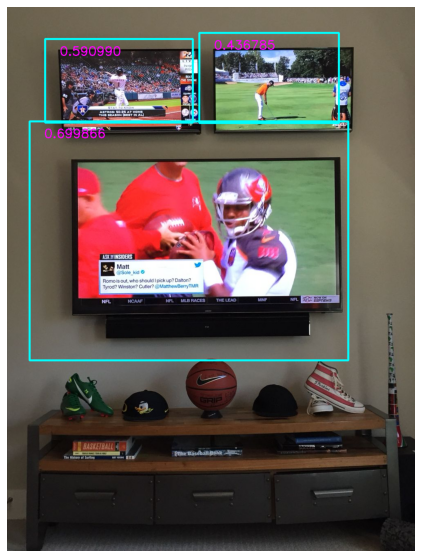

In [49]:
sample = {'image': cv2.imread('./tv_test_image_2.png')}  # Load the image in BGR format

boxes, labels, probs = model.predict(sample, score_threshold=0.4)
for i in range(boxes.size(0)):
    box = boxes[i, :]
    label = f"{probs[i]: 2f}"
    cv2.rectangle(sample['image'], (int(box[0]), int(box[1])),
                 (int(box[0]) + int(box[2]), int(box[1]) + int(box[3])), (255, 255, 0), 4)
    cv2.putText(sample['image'], label, (int(box[0]) + 20, int(box[1]) + 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255),  2)
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(cv2.cvtColor(sample['image'], cv2.COLOR_BGR2RGB))

Export the model to onnx for furher usage in Lens Studio

In [32]:
onnx_model_path = DIR_TO_SAVE_RESULTS / 'det.onnx'
dummy_input = torch.ones(1, 3, INPUT_SIZE[1], INPUT_SIZE[0],
                         dtype=torch.float32)

In [33]:
# model.load(DIR_TO_SAVE_RESULTS / 'e-75-1.091.pth')  # Use to load saved model snapshot
model.to('cpu')

model.set_conversion_mode(to_convert=True)
model = model.eval()

input_names = ['data']
output_names = ['loc', 'cls']

onnx.export(model, dummy_input, onnx_model_path, verbose=False,
            input_names=input_names, output_names=output_names,
            keep_initializers_as_inputs=True, opset_version=11)

model.set_conversion_mode(to_convert=False)
print("Successfully saved model as {}".format(onnx_model_path))

Successfully saved model as centernet_model/det.onnx


In [34]:
!zip -r ./centernet_model/model.zip ./centernet_model/

  adding: centernet_model/ (stored 0%)
  adding: centernet_model/e-28-0.938.pth (deflated 12%)
  adding: centernet_model/e-36-0.844.pth (deflated 12%)
  adding: centernet_model/e-24-0.967.pth (deflated 12%)
  adding: centernet_model/e-31-0.923.pth (deflated 13%)
  adding: centernet_model/e-30-0.896.pth (deflated 13%)
  adding: centernet_model/e-29-0.895.pth (deflated 12%)
  adding: centernet_model/e-19-0.934.pth (deflated 12%)
  adding: centernet_model/e-15-1.003.pth (deflated 13%)
  adding: centernet_model/e-8-1.147.pth (deflated 12%)
  adding: centernet_model/e-7-1.153.pth (deflated 13%)
  adding: centernet_model/e-27-0.978.pth (deflated 12%)
  adding: centernet_model/e-33-0.844.pth (deflated 12%)
  adding: centernet_model/e-3-1.449.pth (deflated 12%)
  adding: centernet_model/e-25-0.894.pth (deflated 12%)
  adding: centernet_model/e-35-0.850.pth (deflated 12%)
  adding: centernet_model/e-17-0.998.pth (deflated 12%)
  adding: centernet_model/e-1-1.685.pth (deflated 12%)
  adding: cen

In [35]:
from google.colab import files
files.download("./centernet_model/model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>